# Denoise CGM Using Wavelet Transform 
We are trying to clean the data using wavelet transform

* [Cleaning data](#cleaning_data)
* [Denoise Data with DWT ](#denoise_data)
* [Adding noise](#add_noise)

### Import all the required functions

In [6]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import defaultdict
import pywt
import scaleogram as scg
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
from sklearn.metrics import mean_squared_error 
# import the written functions
from CGMfunctions import *
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Investigation
#### Tsalikian 2005 data
The purpose of this study was to find out how often low blood sugar (hypoglycemia) occurs during the night after exercise in late afternoon for children aged 10 to 18 with type 1 diabetes. The total sample size was 50 participants. The OneTouch Ultra Meter was used to continuously monitor glucose levels during two seperate 24 hours periods. <br>
Sample size: 50 <br>
Diabetes Type: Type 1 <br>
Population Group: Children (10-18) <br>
CGM device: OneTouch Ultra Meter <br>
Duration: 48 hours, every 5 minutes <br> 

We want to identify the subjects participating in this research. Then, we aim to split the data into daily segments for each subject and print out basic information about each subject, such as the missing time ranges and the number of records for each day.

In [4]:
tsalikian2005 = pd.read_csv("./data/Tsalikian2005_processed.csv",header = 0,index_col=False)  
tsalikian2005.rename(columns = {'gl': 'Glucose','time':'Time'},inplace = True)
tsalikian2005.id.unique()

array([ 7, 43,  2, 27, 38, 15, 16, 19, 22, 32, 11,  8, 20, 44, 35, 18, 42,
       17, 36, 46, 33, 48,  5, 53, 14, 40, 13, 41, 25, 26, 28,  3, 50, 29,
       24, 12,  9, 23,  1, 10, 54, 39,  4, 37, 31, 30,  6, 52, 21, 45],
      dtype=int64)

In [138]:
Anderson2016 = pd.read_csv("./data/Anderson2016_processed.csv",header = 0,index_col=False)  
Anderson2016.rename(columns = {'gl': 'Glucose','time':'Time'},inplace = True)
Anderson2016.head(3)

,id,Time,Glucose
0,1,2013-09-29 17:36:48,194
1,1,2013-09-29 17:41:48,204
2,1,2013-09-29 17:46:48,201


In [5]:
dfs_good = data_subject_info(tsalikian2005)  # tsalikian2005
allsub_daily_dict = split_by_date_allsub(dfs_good)

There are in total  50 subjects.
The information for subject:  1
There are missing values in the dataset:
- Time: 24 missing values
Missing time range is  [(168, 179), (24626, 24637)]
Records per day:
          Date  Number of Records
0   2000-04-01                288
1   2000-04-02                144
2   2000-04-07                298
3   2000-04-08                174
4   2013-09-29                 77
..         ...                ...
93  2014-02-22                 28
94  2014-02-23                287
95  2014-02-24                279
96  2014-02-25                285
97  2014-02-26                 96

[98 rows x 2 columns]

Total number of days: 98
The information for subject:  2
There are no missing values in the dataset.
Records per day:
           Date  Number of Records
0    2000-02-06                212
1    2000-02-07                146
2    2000-02-15                298
3    2000-02-16                194
4    2013-08-26                 23
..          ...                ...
247 

In [41]:
# count the total number of daily data samples
cnt = 0
for idex, df in allsub_daily_dict.items():
    cnt += len(df)
print(cnt)

5115


## Cleaning data <a class="anchor" id="cleaning_data"></a>
The first step, we want to filter out the daily data with more than 240 records, which contains at least 20 hours consecutive records. 

In [6]:
allsub_daily_240_dict = filter_dfdict_by_record_count(allsub_daily_dict,240) 
print(len(allsub_daily_240_dict))
allsub_chunk_dict = split_crossover_timechunk(allsub_daily_240_dict)
allsub_chunk_dict2 = remove_dup_dicts(allsub_chunk_dict)
allsub_combokey_dict = combine_2keys(allsub_chunk_dict2)
allsub_2key_dict = split_combined_2keys(allsub_combokey_dict)


1282


## Denoise Data with DWT <a class="anchor" id="denoise_data"></a>

In [7]:
wavelet_candidates = ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7',
                          'bior3.9', 'bior4.4','coif2','coif10', 'coif16','db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11',
                          'db12', 'db15', 'db25',  'haar', 'rbio1.5', 'rbio3.1', 'rbio6.8']
level_candidates = [2,3,4,5,6]

Check the proper number of decomposition for the DWT (based on the length of original data)

In [8]:
w = pywt.Wavelet('bior3.9')
print(pywt.dwt_max_level(data_len=288, filter_len=w.dec_len))

3


In [13]:
all_param_daily_df,all_param_daily_dict = get_best_parameters_allsubject_alldates(allsub_combokey_dict,wavelet_candidates,level_candidates)

: 

In [ ]:
denoised_signal_dict = denoised_cgm_allsub_daily(allsub_2key_dict,all_param_daily_df)

In [7]:
### open the denoised dict data saved before###
import pickle
with open('denoised_tsalikian_signal_dict.pkl', 'rb') as fp:
    denoised_signal_dict = pickle.load(fp)
    #print(denoised_signal_dict)

In [14]:
# print out all the keys for each subject and each date
# print_all_2keys(allsub_2key_dict)

Choose one subject on one date to plot

In [67]:
date =  '2012-07-12'  #2000-04-07'
subject = '2012-07-12_11' #'2000-04-07_31'
one_subject_org = allsub_2key_dict[date][subject]
#one_sub_denoised = denoised_signal_dict[date][subject]

### Add labe to the dataframe and compare the label changes after denosing

In [78]:
aallsub__2keydict_labels = label_glucose(allsub_2key_dict) 
original_label_df = label_summary_df(aallsub__2keydict_labels)

In [79]:
print(sum(original_label_df['Label']))
original_label_df.shape

2410


(4753, 3)

In [82]:
original_label_df['subject_only'] = original_label_df['subject'].apply(lambda x: x.split('_')[-1])
summary = original_label_df.groupby('subject_only')['Label'].sum().reset_index()

In [186]:
denoised_signal_dict_labels = label_denoised_glucose(denoised_signal_dict)
denoised_label_df = label_summary_df(denoised_signal_dict_labels)

In [187]:
denoised_label_df['subject_only'] = denoised_label_df['subject'].apply(lambda x: x.split('_')[-1])
summary2 = denoised_label_df.groupby('subject_only')['Label'].sum().reset_index()
print(sum(denoised_label_df['Label']))

2370


In [188]:
result = compare_label_dfs(original_label_df,denoised_label_df).drop(columns=['Label_difference','subject_only_df2'])
#print(result.head(3))
print('There are ', sum(result['Label_df1']), 'records changes from 1 to 0.')
print('There are ', sum(result['Label_df2']), 'records changes from 0 to 1.')

There are  6 records changes from 1 to 0.
There are  59 records changes from 0 to 1.


## Add Noise to Data and simulations  <a class="anchor" id="add_noise"></a>

In [28]:
date =  '2012-07-12'  #2000-04-07'
subject = '2012-07-12_11' #'2000-04-07_31'
one_subject_org = allsub_2key_dict[date][subject]
#one_sub_denoised = denoised_signal_dict[date][subject]
#interactive_compare(one_subject_org,one_sub_denoised)
noisy_one_df = add_noise_to_spikeglucose(one_subject_org, 2)
one_para_df, one_allresult = get_best_parameters_onesub(noisy_one_df,wavelet_candidates,level_candidates)
best_wavelet, best_level = best_parameter(one_para_df)
print(best_wavelet,best_level)
final_reconstructed = dwt_denoise(noisy_one_df["Glucose"],wavelet=best_wavelet, level=best_level, thresholding='hard')
print(get_metrics(noisy_one_df['Glucose'],final_reconstructed))
interactive_compare_three(one_subject_org,noisy_one_df,final_reconstructed)

bior3.9 2
        MSE       PSNR        SNR       R^2
0  2.678878  46.603992  37.924225  0.999475


Loading BokehJS ...

In [23]:
#plot_compare_zoom(one_subject_org, one_sub_denoised)

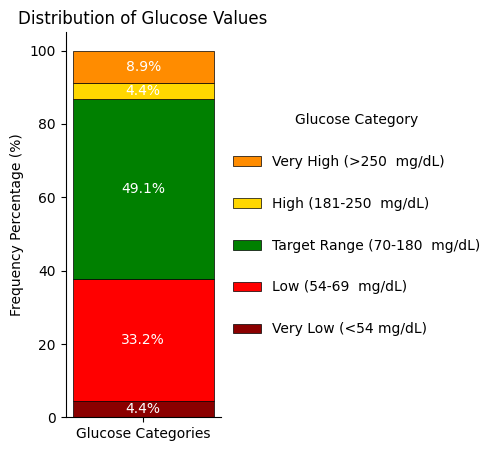

In [58]:
plot_TR_bar(one_subject_org)

In [27]:
#plot_TR_bar(noisy_one_df)

In [28]:
#plot_TR_bar_reconstructed(final_reconstructed)

### Simulations on one piece of data

In [25]:
noise_level = [1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,8,9,10]
n_sim = 500
org_mse_values = []
denoise_mse_values = []
org_psnr_values = []
denoise_psnr_values = []
org_snr_values = []
denoise_snr_values = []
mse_changes = []
psnr_changes = []
snr_changes = []
snr_out,snr_in = [],[]
mse_out,mse_in = [],[]
cv0s,cv1s,cv2s,sd0s,sd1s,sd2s,mage0s,mage1s,mage2s, eA1c1s, eA1c2s  = [],[],[],[],[],[],[],[],[],[],[]
cv_0,cv_1,cv_2,sd_0,sd_1,sd_2,mage_0,mage_1,mage_2, eA1c_0, eA1c_1, eA1c_2 = [],[],[],[],[],[],[],[],[],[],[],[]
hamming_1s,hamming_2s,jaccard_1s,jaccard_2s,rate_0_to_1s,rate_1_to_0s,rate_0_to_0s,rate_1_to_1s = [],[],[],[],[],[],[],[]
hammingdistance1s,hammingdistance2s,jaccard_distance1s,jaccard_distance2s,rates_0_to_1,rates_1_to_0,rates_0_to_0,rates_1_to_1 = [],[],[],[],[],[],[],[]
cv1_lower, cv1_upper, cv2_lower, cv2_upper = [],[], [],[]
jaccard_distance1s_lower,jaccard_distance1s_upper, jaccard_distance2s_lower,jaccard_distance2s_upper = [],[], [],[]
snr_out_lower,snr_out_upper,mse_out_lower,mse_out_upper,mse_in_lower,mse_in_upper = [],[],[],[],[],[]
sd1_lower,sd1_upper,sd2_lower,sd2_upper = [],[],[],[]
mage1_lower,mage1_upper,mage2_lower,mage2_upper = [],[],[],[]
eA1c_1_lower, eA1c_1_upper, eA1c_2_lower, eA1c_2_upper = [],[],[],[]
hamming_distance1s_lower,hamming_distance1s_upper, hamming_distance2s_lower,hamming_distance2s_upper = [],[], [],[]
rates_0_to_1_lower,rates_0_to_1_upper, rates_1_to_0_lower, rates_1_to_0_upper = [],[], [],[]
rates_0_to_0_lower,rates_0_to_0_upper, rates_1_to_1_lower, rates_1_to_1_upper = [],[], [],[]

import random
random.seed(118)


for noise_i in noise_level:
    t1 = convert_to_binary(one_subject_org['Glucose'])
    for _  in range(n_sim):
        noisy_one_df = add_noise_to_spikeglucose(one_subject_org, noise_i)
        one_para_df, one_allresult = get_best_parameters_onesub(noisy_one_df,wavelet_candidates,level_candidates)
        best_wavelet, best_level = best_parameter(one_para_df)
        final_reconstructed = dwt_denoise(noisy_one_df["Glucose"],wavelet=best_wavelet, level=best_level, thresholding='hard')
        org_mse_values.append(get_metrics(one_subject_org['Glucose'],noisy_one_df['Glucose'])['MSE'].values)
        denoise_mse_values.append(get_metrics(one_subject_org['Glucose'],final_reconstructed)['MSE'].values)
        org_psnr_values.append(get_metrics(one_subject_org['Glucose'],noisy_one_df['Glucose'])['PSNR'].values)
        denoise_psnr_values.append(get_metrics(one_subject_org['Glucose'],final_reconstructed)['PSNR'].values)
        org_snr_values.append(get_metrics(one_subject_org['Glucose'],noisy_one_df['Glucose'])['SNR'].values)
        denoise_snr_values.append(get_metrics(one_subject_org['Glucose'],final_reconstructed)['SNR'].values)
        n_sig = len(final_reconstructed)
        sd1, cv1, eA1c1 = calculate_cgm_metrics(noisy_one_df['Glucose'])
        sd2, cv2, eA1c2 = calculate_cgm_metrics(final_reconstructed)
        test_df = one_subject_org.copy()
        test_df['Glucose'] = final_reconstructed
        mage1 = MAGE(noisy_one_df)
        mage2 = MAGE(test_df)
        cv1s.append(cv1)
        cv2s.append(cv2)
        sd1s.append(sd1)
        sd2s.append(sd2)
        mage1s.append(mage1)
        mage2s.append(mage2)
        eA1c1s.append(eA1c1)
        eA1c2s.append(eA1c2)
        t2 = convert_to_binary(noisy_one_df['Glucose'].values)
        t3 = convert_to_binary(final_reconstructed)
        hammingdistance1 = hamming_distance(t1,t2)
        hammingdistance2 = hamming_distance(t1,t3)
        jaccard_distance1 = distance.jaccard(t1, t2)
        jaccard_distance2 = distance.jaccard(t1, t3)
        rate_0_to_1, rate_1_to_0, rate_0_to_0, rate_1_to_1 = transition_rates(t1, t3)
        hamming_1s.append(hammingdistance1)
        hamming_2s.append(hammingdistance2)
        jaccard_1s.append(jaccard_distance1)
        jaccard_2s.append(jaccard_distance2)
        rate_0_to_1s.append(rate_0_to_1)
        rate_1_to_0s.append(rate_1_to_0)
        rate_0_to_0s.append(rate_0_to_0)
        rate_1_to_1s.append(rate_1_to_1)


    mse_changes.append((sum(org_mse_values) - sum(denoise_mse_values))/n_sig)
    mse_in.append(np.mean(org_mse_values))
    mse_out.append(np.mean(denoise_mse_values))
    psnr_changes.append((sum(denoise_psnr_values) - sum(org_psnr_values))/n_sig)
    snr_changes.append((sum(denoise_snr_values) - sum(org_snr_values))/n_sig)
    snr_out.append(np.mean(denoise_snr_values))
    snr_in.append(np.mean(org_snr_values))
    sd0, cv0, eA1c0  = calculate_cgm_metrics(one_subject_org['Glucose'])
    mage0 = MAGE(one_subject_org)
    cv_0.append(cv0)
    cv_1.append(np.mean(cv1s))
    cv_2.append(np.mean(cv2s))
    sd_0.append(sd0)
    sd_1.append(np.mean(sd1s))
    sd_2.append(np.mean(sd2s))
    mage_0.append(mage0)
    mage_1.append(np.mean(mage1s))
    mage_2.append(np.mean(mage2s))
    eA1c_0.append(eA1c0)
    eA1c_1.append(np.mean(eA1c1s))
    eA1c_2.append(np.mean(eA1c2s))
    hammingdistance1s.append(np.mean(hamming_1s))
    hammingdistance2s.append(np.mean(hamming_2s))
    jaccard_distance1s.append(np.mean(jaccard_1s))
    jaccard_distance2s.append(np.mean(jaccard_2s))
    rates_0_to_1.append(np.mean(rate_0_to_1s))
    rates_1_to_0.append(np.mean(rate_1_to_0s))
    rates_0_to_0.append(np.mean(rate_0_to_0s))
    rates_1_to_1.append(np.mean(rate_1_to_1s))

    cv1_upper.append(np.mean(cv1s)+np.std(cv1s))
    cv1_lower.append(np.mean(cv1s)-np.std(cv1s))
    cv2_upper.append(np.mean(cv2s)+np.std(cv2s))
    cv2_lower.append(np.mean(cv2s)-np.std(cv2s))

    jaccard_distance1s_lower.append(np.mean(jaccard_1s)-np.std(jaccard_1s))
    jaccard_distance1s_upper.append(np.mean(jaccard_1s)+np.std(jaccard_1s))
    jaccard_distance2s_lower.append(np.mean(jaccard_2s)-np.std(jaccard_2s))
    jaccard_distance2s_upper.append(np.mean(jaccard_2s)+np.std(jaccard_2s))

    hamming_distance1s_lower.append(np.mean(hamming_1s)-np.std(hamming_1s))
    hamming_distance1s_upper.append(np.mean(hamming_1s)+np.std(hamming_1s))
    hamming_distance2s_lower.append(np.mean(hamming_2s)-np.std(hamming_2s))
    hamming_distance2s_upper.append(np.mean(hamming_2s)+np.std(hamming_2s))

    snr_out_lower.append(np.mean(denoise_snr_values) - np.std(denoise_snr_values))
    snr_out_upper.append(np.mean(denoise_snr_values) + np.std(denoise_snr_values))
    mse_out_lower.append(np.mean(denoise_mse_values) - np.std(denoise_mse_values))
    mse_out_upper.append(np.mean(denoise_mse_values) + np.std(denoise_mse_values))
    mse_in_lower.append(np.mean(org_mse_values) - np.std(org_mse_values))
    mse_in_upper.append(np.mean(org_mse_values) + np.std(org_mse_values))

    sd1_lower.append(np.mean(sd1s) - np.std(sd1s))
    sd1_upper.append(np.mean(sd1s) + np.std(sd1s))
    sd2_lower.append(np.mean(sd2s) - np.std(sd2s))
    sd2_upper.append(np.mean(sd2s) + np.std(sd2s))

    eA1c_1_lower.append(np.mean(eA1c1s) - np.std(eA1c1s))
    eA1c_1_upper.append(np.mean(eA1c1s) + np.std(eA1c1s))
    eA1c_2_lower.append(np.mean(eA1c2s) - np.std(eA1c2s))
    eA1c_2_upper.append(np.mean(eA1c2s) + np.std(eA1c2s))

    mage1_lower.append(np.mean(mage1s) - np.std(mage1s))
    mage1_upper.append(np.mean(mage1s) + np.std(mage1s))
    mage2_lower.append(np.mean(mage2s) - np.std(mage2s))
    mage2_upper.append(np.mean(mage2s) + np.std(mage2s))

    rates_0_to_1_lower.append(np.mean(rate_0_to_1s) - np.std(rate_0_to_1s))
    rates_0_to_1_upper.append(np.mean(rate_0_to_1s) + np.std(rate_0_to_1s))
    rates_1_to_0_lower.append(np.mean(rate_1_to_0s) - np.std(rate_1_to_0s))
    rates_1_to_0_upper.append(np.mean(rate_1_to_0s) + np.std(rate_1_to_0s))

    rates_0_to_0_lower.append(np.mean(rate_0_to_0s) - np.std(rate_0_to_0s))
    rates_0_to_0_upper.append(np.mean(rate_0_to_0s) + np.std(rate_0_to_0s))
    rates_1_to_1_lower.append(np.mean(rate_1_to_1s) - np.std(rate_1_to_1s))
    rates_1_to_1_upper.append(np.mean(rate_1_to_1s) + np.std(rate_1_to_1s))


In [26]:
sim_result = pd.DataFrame({
    'noise_levels': noise_level,
    'MSE_changes': mse_changes,
    'PSNR_changes': psnr_changes,
    'SNR_changes': snr_changes,
    'SNR_in': snr_in,
    'SNR_out': snr_out,
    'MSE_out': mse_out,
    'MSE_in': mse_in,
    'cv_org': cv_0,
    'cv_noise': cv_1,
    'cv_denoise': cv_2,
    'sd_org': sd_0,
    'sd_noise': sd_1,
    'sd_denoise': sd_2,
    'mage_org': mage_0,
    'mage_noise': mage_1,
    'mage_denoise': mage_2,
    'eHbA1c_org': eA1c_0,
    'eHbA1c_noise': eA1c_1,
    'eHbA1c_denoise': eA1c_2,
    'hamming_distance1': hammingdistance1s,
    'hamming_distance2': hammingdistance2s,
    'jaccard_distance1':jaccard_distance1s,
    'jaccard_distance2':jaccard_distance2s,
    'rates_0_to_1':rates_0_to_1,
    'rates_1_to_0': rates_1_to_0,
    'rates_0_to_0':rates_0_to_0,
    'rates_1_to_1': rates_1_to_1,
    'cv2_upper':cv2_upper,
    'cv2_lower':cv2_lower,
    'cv1_lower': cv1_lower,
    'cv1_upper': cv1_upper,
    'jaccard_distance1s_lower':jaccard_distance1s_lower,
    'jaccard_distance1s_upper':jaccard_distance1s_upper,
    "jaccard_distance2s_lower":jaccard_distance2s_lower,
    'jaccard_distance2s_upper':jaccard_distance2s_upper,
    'hamming_distance1s_lower':hamming_distance1s_lower,
    'hamming_distance1s_upper':hamming_distance1s_upper,
    "hamming_distance2s_lower":hamming_distance2s_lower,
    'hamming_distance2s_upper':hamming_distance2s_upper,
    'snr_out_lower': snr_out_lower,
    'snr_out_upper':snr_out_upper,
    'mse_out_lower':mse_out_lower,
    'mse_out_upper': mse_out_upper,
    'mse_in_lower':mse_in_lower,
    'mse_in_upper': mse_in_upper,
    'sd1_lower':sd1_lower,
    'sd1_upper':sd1_upper,
    'sd2_lower':sd2_lower,
    'sd2_upper':sd2_upper,
    'mage1_lower':mage1_lower,
    'mage1_upper':mage1_upper,
    'mage2_lower':mage2_lower,
    'mage2_upper':mage2_upper,
    'eHbA1c1_lower':eA1c_1_lower,
    'eHbA1c1_upper':eA1c_1_upper,
    'eHbA1c2_lower':eA1c_2_lower,
    'eHbA1c2_upper':eA1c_2_upper,
    'rates_0_to_1_lower':rates_0_to_1_lower,
    'rates_0_to_1_upper':rates_0_to_1_upper, 
    'rates_1_to_0_lower':rates_1_to_0_lower, 
    'rates_1_to_0_upper':rates_1_to_0_upper,
    'rates_0_to_0_lower':rates_0_to_0_lower,
    'rates_0_to_0_upper':rates_0_to_0_upper, 
    'rates_1_to_1_lower':rates_1_to_1_lower, 
    'rates_1_to_1_upper':rates_1_to_1_upper

})

In [8]:
##### save and reload the sim result
#sim_result.to_csv('./data/sim_500_results_2.csv', index=False)
sim_result = pd.read_csv('./data/sim_500_results_2.csv')

In [39]:
sim_result['SNR_changes']=sim_result['SNR_changes'].astype(float)

ValueError: could not convert string to float: '[-4.83620623]'

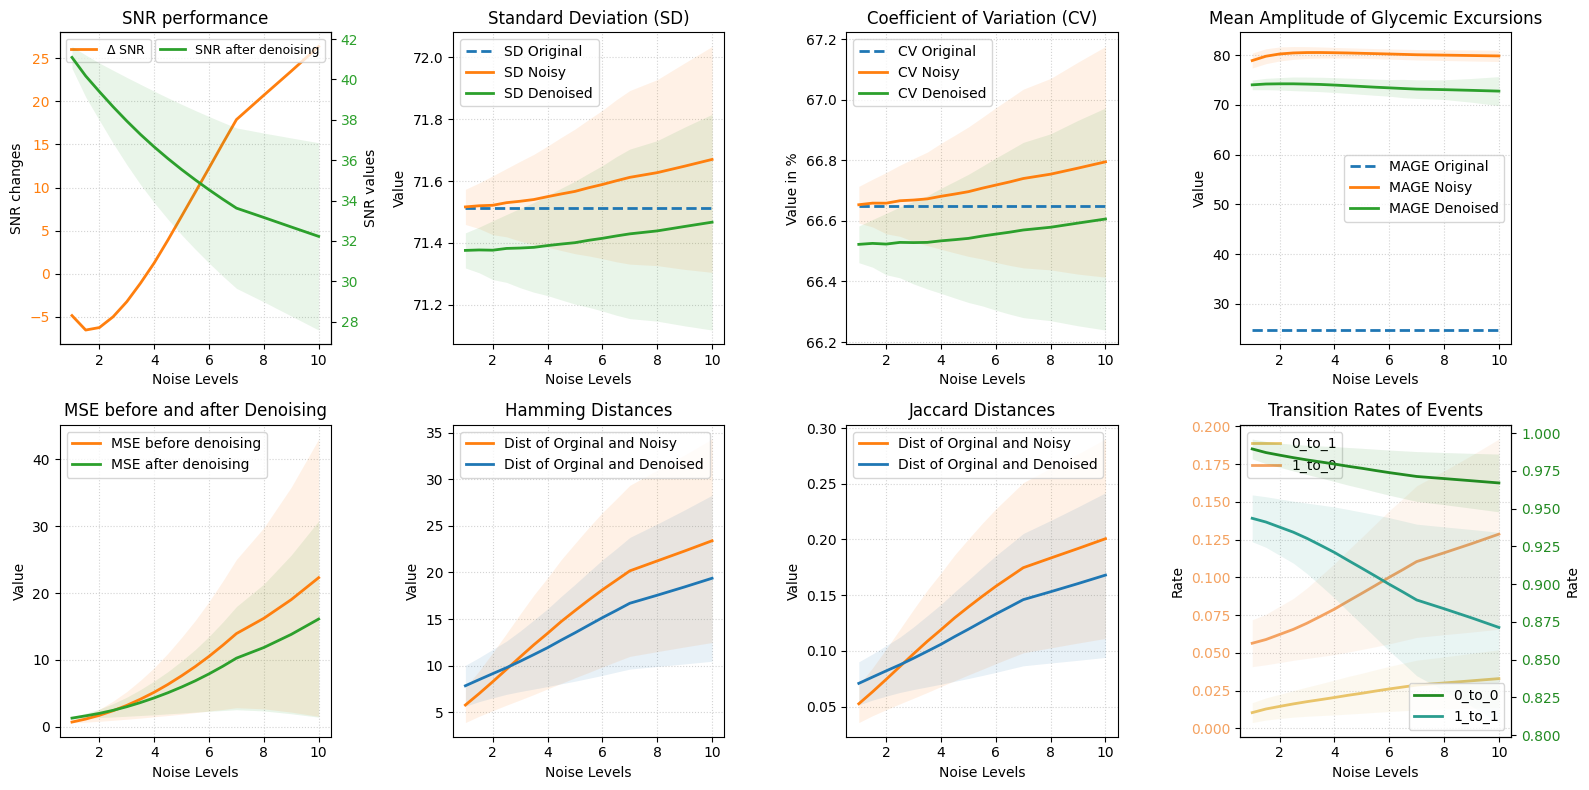

In [98]:
plot_sim_result(sim_result)
# plot_sim_result(sim_result,'sim_500.png')

In [20]:
#plot_sim_ehb_rate(sim_result)

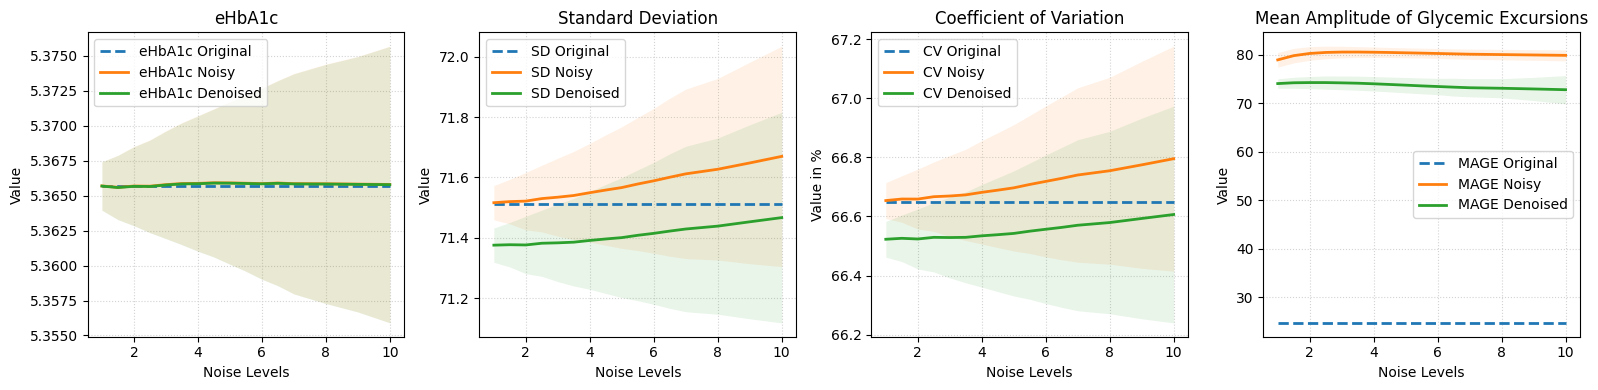

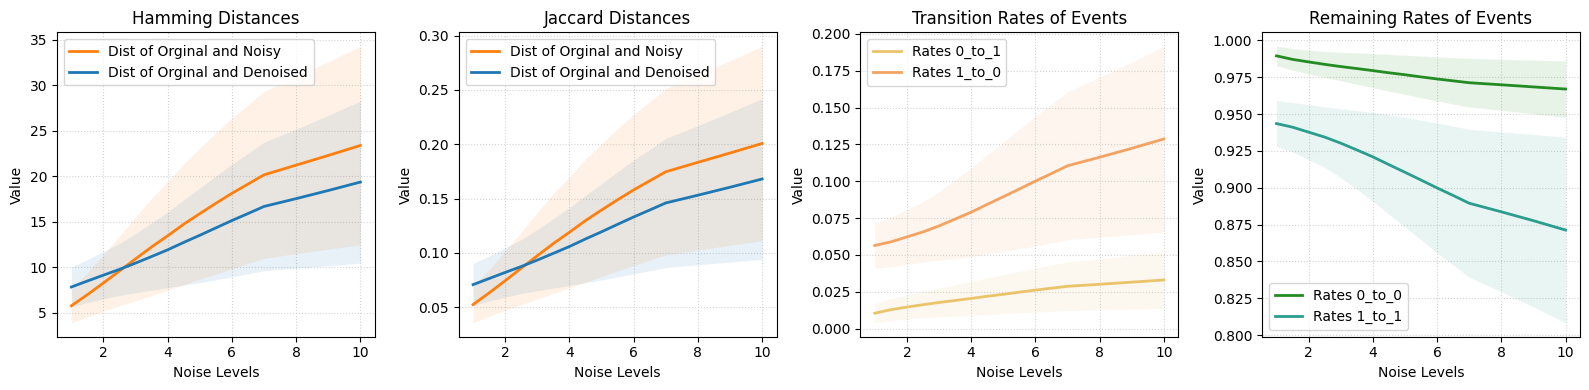

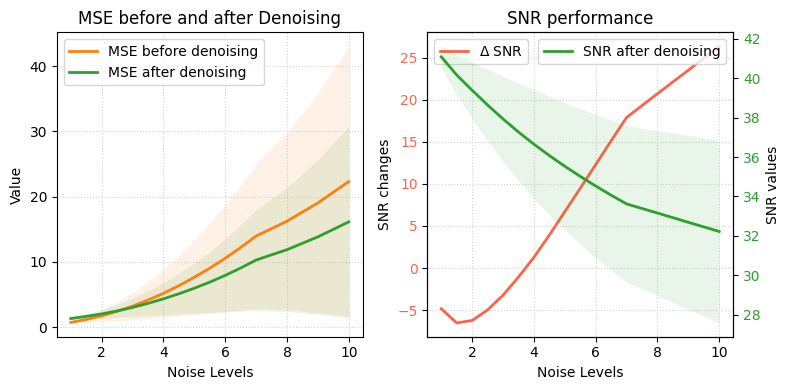

In [96]:
# plot_sim_variance(sim_result_loaded,'sim_500_sd.png')
# plot_sim_distance(sim_result_loaded,'sim_500_dist.png')
# plot_sim_msesnr(sim_result_loaded,'sim_500_snr.png')
plot_sim_variance(sim_result,'sim_500_sd.png')
plot_sim_distance(sim_result,'sim_500_dist.png')
plot_sim_msesnr(sim_result,'sim_500_snr.png')

### Simulate on another data with clear trend

In [9]:
date =  '2012-07-12'  #2000-04-07'
subject = '2012-07-12_11' #'2000-04-07_31'
one_subject_org = allsub_2key_dict[date][subject]
#one_sub_denoised = denoised_signal_dict[date][subject]
#interactive_compare(one_subject_org,one_sub_denoised)
noisy_one_df = add_noise_to_spikeglucose(one_subject_org, 10)  #add_noise_to_snr  add_noise_to_spikeglucose
one_para_df, one_allresult = get_best_parameters_onesub(noisy_one_df,wavelet_candidates,level_candidates)
best_wavelet, best_level = best_parameter(one_para_df)
print(best_wavelet,best_level)
final_reconstructed = dwt_denoise(noisy_one_df["Glucose"],wavelet=best_wavelet, level=best_level, thresholding='hard')
print(get_metrics(noisy_one_df['Glucose'],final_reconstructed))
#interactive_compare_three(one_subject_org,noisy_one_df,final_reconstructed)

bior2.6 2
         MSE       PSNR        SNR       R^2
0  21.663154  38.031804  28.914464  0.995927


In [76]:
noise_level = [1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,8,9,10]
n_sim = 50
org_mse_values = []
denoise_mse_values = []
org_psnr_values = []
denoise_psnr_values = []
org_snr_values = []
denoise_snr_values = []
mse_changes = []
psnr_changes, psnr_in, psnr_out = [],[],[]
snr_changes = []
snr_out,snr_in = [],[]
mse_out,mse_in = [],[]
cv0s,cv1s,cv2s,sd0s,sd1s,sd2s,mage0s,mage1s,mage2s  = [],[],[],[],[],[],[],[],[]
cv_0,cv_1,cv_2,sd_0,sd_1,sd_2,mage_0,mage_1,mage_2 = [],[],[],[],[],[],[],[],[]
hamming_1s,hamming_2s,jaccard_1s,jaccard_2s,rate_0_to_1s,rate_1_to_0s = [],[],[],[],[],[]
hammingdistance1s,hammingdistance2s,jaccard_distance1s,jaccard_distance2s,rates_0_to_1,rates_1_to_0 = [],[],[],[],[],[]
cv1_lower, cv1_upper, cv2_lower, cv2_upper = [],[], [],[]
jaccard_distance1s_lower,jaccard_distance1s_upper, jaccard_distance2s_lower,jaccard_distance2s_upper = [],[], [],[]
snr_out_lower,snr_out_upper,mse_out_lower,mse_out_upper,mse_in_lower,mse_in_upper = [],[],[],[],[],[]
sd1_lower,sd1_upper,sd2_lower,sd2_upper = [],[],[],[]
mage1_lower,mage1_upper,mage2_lower,mage2_upper = [],[],[],[]
hamming_distance1s_lower,hamming_distance1s_upper, hamming_distance2s_lower,hamming_distance2s_upper = [],[], [],[]
rates_0_to_1_lower,rates_0_to_1_upper, rates_1_to_0_lower, rates_1_to_0_upper = [],[], [],[]

import random
random.seed(118)


for noise_i in noise_level:
    t1 = convert_to_binary(one_subject_org['Glucose'])
    for _  in range(n_sim):
        noisy_one_df = add_noise_to_spikeglucose(one_subject_org, noise_i)   #add_noise_to_allglucose  add_noise_to_spikeglucose
        one_para_df, one_allresult = get_best_parameters_onesub(noisy_one_df,wavelet_candidates,level_candidates)
        best_wavelet, best_level = best_parameter(one_para_df)
        final_reconstructed = dwt_denoise(noisy_one_df["Glucose"],wavelet=best_wavelet, level=best_level, thresholding='hard')
        org_mse_values.append(get_metrics(one_subject_org['Glucose'],noisy_one_df['Glucose'])['MSE'].values)
        denoise_mse_values.append(get_metrics(one_subject_org['Glucose'],final_reconstructed)['MSE'].values)
        org_psnr_values.append(get_metrics(one_subject_org['Glucose'],noisy_one_df['Glucose'])['PSNR'].values)
        denoise_psnr_values.append(get_metrics(one_subject_org['Glucose'],final_reconstructed)['PSNR'].values)
        org_snr_values.append(get_metrics(one_subject_org['Glucose'],noisy_one_df['Glucose'])['SNR'].values)
        denoise_snr_values.append(get_metrics(one_subject_org['Glucose'],final_reconstructed)['SNR'].values)
        n_sig = len(final_reconstructed)
        sd1, cv1, mage1 = calculate_cgm_metrics(noisy_one_df['Glucose'])
        sd2, cv2, mage2 = calculate_cgm_metrics(final_reconstructed)
        cv1s.append(cv1)
        cv2s.append(cv2)
        sd1s.append(sd1)
        sd2s.append(sd2)
        mage1s.append(mage1)
        mage2s.append(mage2)
        t2 = convert_to_binary(noisy_one_df['Glucose'].values)
        t3 = convert_to_binary(final_reconstructed)
        hammingdistance1 = hamming_distance(t1,t2)
        hammingdistance2 = hamming_distance(t1,t3)
        jaccard_distance1 = distance.jaccard(t1, t2)
        jaccard_distance2 = distance.jaccard(t1, t3)
        rate_0_to_1, rate_1_to_0 = transition_rates(t1, t3)
        hamming_1s.append(hammingdistance1)
        hamming_2s.append(hammingdistance2)
        jaccard_1s.append(jaccard_distance1)
        jaccard_2s.append(jaccard_distance2)
        rate_0_to_1s.append(rate_0_to_1)
        rate_1_to_0s.append(rate_1_to_0)


    mse_changes.append((sum(org_mse_values) - sum(denoise_mse_values))/n_sig)
    mse_in.append(np.mean(org_mse_values))
    mse_out.append(np.mean(denoise_mse_values))
    psnr_changes.append((sum(denoise_psnr_values) - sum(org_psnr_values))/n_sig)
    psnr_in.append(np.mean(org_psnr_values))
    psnr_out.append(np.mean(denoise_psnr_values))
    snr_changes.append((sum(denoise_snr_values) - sum(org_snr_values))/n_sig)
    snr_in.append(np.mean(org_snr_values))
    snr_out.append(np.mean(denoise_snr_values))
    sd0, cv0, mage0 = calculate_cgm_metrics(one_subject_org['Glucose'])
    cv_0.append(cv0)
    cv_1.append(np.mean(cv1s))
    cv_2.append(np.mean(cv2s))
    sd_0.append(sd0)
    sd_1.append(np.mean(sd1s))
    sd_2.append(np.mean(sd2s))
    mage_0.append(mage0)
    mage_1.append(np.mean(mage1s))
    mage_2.append(np.mean(mage2s))
    hammingdistance1s.append(np.mean(hamming_1s))
    hammingdistance2s.append(np.mean(hamming_2s))
    jaccard_distance1s.append(np.mean(jaccard_1s))
    jaccard_distance2s.append(np.mean(jaccard_2s))
    rates_0_to_1.append(np.mean(rate_0_to_1s))
    rates_1_to_0.append(np.mean(rate_1_to_0s))

    cv1_upper.append(np.mean(cv1s)+np.std(cv1s))
    cv1_lower.append(np.mean(cv1s)-np.std(cv1s))
    cv2_upper.append(np.mean(cv2s)+np.std(cv2s))
    cv2_lower.append(np.mean(cv2s)-np.std(cv2s))

    jaccard_distance1s_lower.append(np.mean(jaccard_1s)-np.std(jaccard_1s))
    jaccard_distance1s_upper.append(np.mean(jaccard_1s)+np.std(jaccard_1s))
    jaccard_distance2s_lower.append(np.mean(jaccard_2s)-np.std(jaccard_2s))
    jaccard_distance2s_upper.append(np.mean(jaccard_2s)+np.std(jaccard_2s))

    hamming_distance1s_lower.append(np.mean(hamming_1s)-np.std(hamming_1s))
    hamming_distance1s_upper.append(np.mean(hamming_1s)+np.std(hamming_1s))
    hamming_distance2s_lower.append(np.mean(hamming_2s)-np.std(hamming_2s))
    hamming_distance2s_upper.append(np.mean(hamming_2s)+np.std(hamming_2s))

    snr_out_lower.append(np.mean(denoise_snr_values) - np.std(denoise_snr_values))
    snr_out_upper.append(np.mean(denoise_snr_values) + np.std(denoise_snr_values))
    mse_out_lower.append(np.mean(denoise_mse_values) - np.std(denoise_mse_values))
    mse_out_upper.append(np.mean(denoise_mse_values) + np.std(denoise_mse_values))
    mse_in_lower.append(np.mean(org_mse_values) - np.std(org_mse_values))
    mse_in_upper.append(np.mean(org_mse_values) + np.std(org_mse_values))

    sd1_lower.append(np.mean(sd1s) - np.std(sd1s))
    sd1_upper.append(np.mean(sd1s) + np.std(sd1s))
    sd2_lower.append(np.mean(sd2s) - np.std(sd2s))
    sd2_upper.append(np.mean(sd2s) + np.std(sd2s))

    mage1_lower.append(np.mean(mage1s) - np.std(mage1s))
    mage1_upper.append(np.mean(mage1s) + np.std(mage1s))
    mage2_lower.append(np.mean(mage2s) - np.std(mage2s))
    mage2_upper.append(np.mean(mage2s) + np.std(mage2s))

    rates_0_to_1_lower.append(np.mean(rate_0_to_1s) - np.std(rate_0_to_1s))
    rates_0_to_1_upper.append(np.mean(rate_0_to_1s) + np.std(rate_0_to_1s))
    rates_1_to_0_lower.append(np.mean(rate_1_to_0s) - np.std(rate_1_to_0s))
    rates_1_to_0_upper.append(np.mean(rate_1_to_0s) + np.std(rate_1_to_0s))


In [77]:
sim_result2 = pd.DataFrame({
    'noise_levels': noise_level,
    'MSE_changes': mse_changes,
    'PSNR_changes': psnr_changes,
    'PSNR_in':psnr_in,
    'PSNR_out': psnr_out,
    'SNR_changes': snr_changes,
    'SNR_out': snr_out,
    'SNR_in':snr_in,
    'MSE_in': mse_in,
    'MSE_out': mse_out,
    'cv_org': cv_0,
    'cv_noise': cv_1,
    'cv_denoise': cv_2,
    'sd_org': sd_0,
    'sd_noise': sd_1,
    'sd_denoise': sd_2,
    'mage_org': mage_0,
    'mage_noise': mage_1,
    'mage_denoise': mage_2,
    'hamming_distance1': hammingdistance1s,
    'hamming_distance2': hammingdistance2s,
    'jaccard_distance1':jaccard_distance1s,
    'jaccard_distance2':jaccard_distance2s,
    'rates_0_to_1':rates_0_to_1,
    'rates_1_to_0': rates_1_to_0,
    'cv2_upper':cv2_upper,
    'cv2_lower':cv2_lower,
    'cv1_lower': cv1_lower,
    'cv1_upper': cv1_upper,
    'jaccard_distance1s_lower':jaccard_distance1s_lower,
    'jaccard_distance1s_upper':jaccard_distance1s_upper,
    "jaccard_distance2s_lower":jaccard_distance2s_lower,
    'jaccard_distance2s_upper':jaccard_distance2s_upper,
    'hamming_distance1s_lower':hamming_distance1s_lower,
    'hamming_distance1s_upper':hamming_distance1s_upper,
    "hamming_distance2s_lower":hamming_distance2s_lower,
    'hamming_distance2s_upper':hamming_distance2s_upper,
    'snr_out_lower': snr_out_lower,
    'snr_out_upper':snr_out_upper,
    'mse_out_lower':mse_out_lower,
    'mse_out_upper': mse_out_upper,
    'mse_in_lower':mse_in_lower,
    'mse_in_upper': mse_in_upper,
    'sd1_lower':sd1_lower,
    'sd1_upper':sd1_upper,
    'sd2_lower':sd2_lower,
    'sd2_upper':sd2_upper,
    'mage1_lower':mage1_lower,
    'mage1_upper':mage1_upper,
    'mage2_lower':mage2_lower,
    'mage2_upper':mage2_upper,
    'mage1_lower':mage1_lower,
    'mage1_upper':mage1_upper,
    'mage2_lower':mage2_lower,
    'mage2_upper':mage2_upper,
    'rates_0_to_1_lower':rates_0_to_1_lower,
    'rates_0_to_1_upper':rates_0_to_1_upper, 
    'rates_1_to_0_lower':rates_1_to_0_lower, 
    'rates_1_to_0_upper':rates_1_to_0_upper

})

In [15]:
#plot_sim_result(sim_result2)

In [81]:
# plot_sim_variance(sim_result2)
# plot_sim_distance(sim_result2)
# plot_sim_msesnr(sim_result2)

In [16]:
def count_hypoglycemia_episodes(glucose_values, threshold=70):
    episodes = []
    current_length = 0
    
    for value in glucose_values:
        if value < threshold:
            current_length += 1
        else:
            if current_length > 0:
                episodes.append(current_length)
                current_length = 0
    
    # Append the last episode if it ends at the last element
    if current_length > 0:
        episodes.append(current_length)
    
    return len(episodes), episodes

def convert_to_binary(glucose_values, threshold=70):
    binary_array = [1 if value <= threshold else 0 for value in glucose_values]
    return binary_array

test= [x+1 for x in one_subject_org['Glucose']]
num_episodes, durations = count_hypoglycemia_episodes(final_reconstructed)
print(f"Number of hypoglycemia episodes: {num_episodes}")
print(f"Durations of hypoglycemia episodes: {durations}")
num_episodes, durations = count_hypoglycemia_episodes(one_subject_org['Glucose'].values)
print(f"Number of hypoglycemia episodes: {num_episodes}")
print(f"Durations of hypoglycemia episodes: {durations}")
num_episodes, durations = count_hypoglycemia_episodes(test)
print(f"Number of hypoglycemia episodes: {num_episodes}")
print(f"Durations of hypoglycemia episodes: {durations}")
t1 = convert_to_binary(test)
t2 = convert_to_binary(one_subject_org['Glucose'].values)
t3 = convert_to_binary(final_reconstructed)


Number of hypoglycemia episodes: 14
Durations of hypoglycemia episodes: [1, 24, 6, 17, 10, 1, 1, 1, 11, 2, 18, 1, 3, 1]
Number of hypoglycemia episodes: 8
Durations of hypoglycemia episodes: [52, 9, 12, 2, 23, 1, 2, 1]
Number of hypoglycemia episodes: 7
Durations of hypoglycemia episodes: [3, 48, 9, 11, 22, 2, 1]


In [99]:
from scipy.spatial import distance
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Strings must be of the same length")
    distance = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            distance += 1
    return distance
hammingdistance = hamming_distance(vec1,vec2)
print(hammingdistance)
jaccard_distance = distance.jaccard(vec1, vec2)
print(jaccard_distance)
#dice_distance = 1 - (2 * np.sum(vec1 & vec2) / (np.sum(vec1) + np.sum(vec2)))
#print(dice_distance)
cosine_distance = distance.cosine(vec1, vec2)
print(cosine_distance)
    # Manhattan Distance
manhattan_distance = distance.cityblock(vec1, vec2)
print(manhattan_distance) 
    # Euclidean Distance
euclidean_distance = distance.euclidean(vec1, vec2)
print(euclidean_distance)
def transition_rates(t1, t2):
    vec1 = np.array(t1)
    vec2 = np.array(t2)
    if len(vec1) != len(vec2):
        raise ValueError("Vectors must be of the same length.")
    
    zeros_to_ones = np.sum((vec1 == 0) & (vec2 == 1))
    ones_to_zeros = np.sum((vec1 == 1) & (vec2 == 0))
    
    total_zeros = np.sum(vec1 == 0)
    total_ones = np.sum(vec1 == 1)
    
    rate_zeros_to_ones = zeros_to_ones / total_zeros if total_zeros > 0 else 0
    rate_ones_to_zeros = ones_to_zeros / total_ones if total_ones > 0 else 0
    
    return rate_zeros_to_ones, rate_ones_to_zeros
rate_0_to_1, rate_1_to_0 = transition_rates(vec1, vec2)
print(rate_0_to_1,rate_1_to_0)

7
0.06422018348623854
0.03264287023159773
7
2.6457513110645907
0.04142011834319527 0.0


## Plot for one subject with all different dates

In [232]:
all_sub_all_date = rearrange_subaskey_dict(allsub_chunk_dict2)

In [239]:
one_sub_all_date = all_sub_all_date[16]

In [240]:
daily_metrics_dict, daily_param_dict = get_best_parameters_onesubject_alldates(one_sub_all_date,wavelet_candidates, level_candidates)
daily_reconstructions= get_reconstruct_daily(one_sub_all_date,daily_param_dict)

In [330]:
## this code give the interactive plots for each day of one subject
# interactive_daily_compare(one_sub_all_date,daily_reconstructions)

In [84]:
def add_noise_to_spikeglucose(df, sigma):
    noisy_df = df.copy()
    glucose_values = noisy_df['Glucose']
    noise_indices = set()
    
    critical_indices = glucose_values[(glucose_values < 70) | (glucose_values > 180)].index
    #critical_indices = glucose_values[(glucose_values < 70)].index
    
    for idx in critical_indices:
        start_idx = max(0, idx - 5)
        end_idx = min(len(glucose_values), idx + 6)  # Use +6 because range end is exclusive
        noise_indices.update(range(start_idx, end_idx))
    
    noise_indices = list(noise_indices)
    noise = np.random.normal(0, sigma, len(noise_indices))
    noisy_df.loc[noise_indices, 'Glucose'] += noise
    
    return noisy_df

In [34]:
def combine_2keys(nested_dict):
    combined_dict = {}
    for middle_key, inner_dict in nested_dict.items():
        for inner_key, value in inner_dict.items():
            combined_key = f"{middle_key}_{inner_key}"
            combined_dict[combined_key] = value
    return combined_dict

def split_combined_2keys(combined_dict):
    separated_dict = {}
    for combined_key, df in combined_dict.items():
        outer_key, middle_key = combined_key.split('_', 1)
        if outer_key not in separated_dict:
            separated_dict[outer_key] = {}
        others_key = f"{outer_key}_{middle_key}"
        separated_dict[outer_key][others_key] = df
    return separated_dict

def denoised_cgm_allsub_daily(allsub_df_dict, all_param_daily_df):
    denoised_signal_allsub = {}
    for date, date_dfs in allsub_df_dict.items():
        final_reconstruct = {}
        
        for subject, df_good in date_dfs.items():
            original_signal = df_good['Glucose'].values
            condition = (all_param_daily_df['subject'] == subject) # & (all_param_daily_df['date']==date)
            best_params = all_param_daily_df[condition]
            
            if best_params.empty:
                #print(f"No parameters found for subject {subject} on date {date}")
                continue
            
            best_wavelet = best_params.iloc[0]['wavelet']
            best_level = best_params.iloc[0]['level']
            final_reconstructed = dwt_denoise(original_signal,wavelet=best_wavelet, level=best_level, thresholding='hard')
            final_reconstruct[subject]=final_reconstructed
        denoised_signal_allsub[date] = final_reconstruct
    return denoised_signal_allsub

def rearrange_subaskey_dict(data_dict):
    new_dict = {}
    for date, subjects_dict in data_dict.items():
        for subject, df in subjects_dict.items():
            if subject not in new_dict:
                new_dict[subject] = df.copy()
            else:
                new_dict[subject] = pd.concat([new_dict[subject], df], ignore_index=True)
    return new_dict

def plot_TR_bar(df):
    conditions = [
        (df['Glucose'] < 54),
        (df['Glucose'] >= 54) & (df['Glucose'] <= 69),
        (df['Glucose'] >= 70) & (df['Glucose'] <= 180),
        (df['Glucose'] >= 181) & (df['Glucose'] <= 250),
        (df['Glucose'] > 250)
    ]
    choices = ['Very Low (<54 mg/dL)', 'Low (54-69  mg/dL)', 'Target Range (70-180  mg/dL)',
            'High (181-250  mg/dL)','Very High (>250  mg/dL)']
    df['Glucose Category'] = pd.cut(df['Glucose'], bins=[-float('inf'), 54, 70, 180, 250, float('inf')],
                                    labels=choices, right=False)
    category_counts = df['Glucose Category'].value_counts(normalize=True).sort_index() * 100

    stacked_data = category_counts.values.reshape(1, -1)
    categories = category_counts.index

    plt.figure(figsize=(2, 5))
    bar_width = 0.2  # Adjust the bar width here
    bottom = np.zeros(stacked_data.shape[0])
    colors_list = ['darkred','red', 'green', 'gold', 'darkorange']

    for i, category in enumerate(categories):
        plt.bar('Glucose Categories', stacked_data[:, i], bottom=bottom, width=bar_width,
                 label=category,color = colors_list[i],edgecolor = "black",linewidth=0.5)
        bottom += stacked_data[:, i]

        for j in range(stacked_data.shape[0]):
            height = stacked_data[j, i]
            plt.text('Glucose Categories', bottom[j] - height / 2, f'{height:.1f}%', ha='center', va='center', color='white', fontsize=10)

    #plt.xlabel('Glucose Categories')
    plt.ylabel('Frequency Percentage (%)')
    plt.title('Distribution of Glucose Values')

    handles, labels = plt.gca().get_legend_handles_labels() 
    order = [4, 3,2, 1, 0] 
    plt.legend([handles[i] for i in order], [labels[i] for i in order],title='Glucose Category',loc='center left', bbox_to_anchor=(1, 0.5),
               fontsize=10,labelspacing=2,frameon=False)
    
    for pos in ['right', 'top']: 
        plt.gca().spines[pos].set_visible(False) 
    plt.show()

def plot_TR_bar_reconstructed(reconstructed):
    final_reconstructed_df = pd.DataFrame()
    final_reconstructed_df['Glucose'] = reconstructed
    plot_TR_bar(final_reconstructed_df)